In [1]:
from sklearn.datasets import fetch_openml
## 需要重新加载mnist数据时候可以使用
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')
X, y = mnist.data, mnist.target
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# 1

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
acc = knn_clf.score(X_test, y_test)
acc

0.9688

In [4]:
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [2, 4, 6, 8]},
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train[:10000], y_train[:10000])
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [6]:
grid_search.best_estimator_.fit(X_train, y_train)
acc = grid_search.score(X_test, y_test)
acc

0.9714

# 2

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from scipy.ndimage import shift

def shift_image(image, dx, dy): 
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

In [9]:
image = X_train[10000]
image_down = shift_image(image, 0, 5)
image_left = shift_image(image, -5, 0)

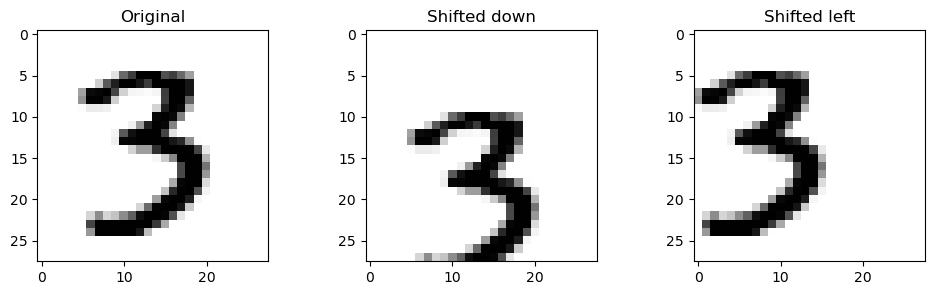

In [10]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(image_down.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(image_left.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.show()

In [12]:
X_train_argument = [image for image in X_train]
y_train_argument = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, -1), (0,1)):
    for image, label in zip(X_train, y_train):
        X_train_argument.append(shift_image(image, dx, dy))
        y_train_argument.append(label)

X_train_argument = np.array(X_train_argument)
y_train_argument = np.array(y_train_argument)

In [13]:
print(X_train_argument.shape, y_train_argument.shape)

(300000, 784) (300000,)


In [14]:
shuffle_idx = np.random.permutation(len(X_train_argument))
X_train_augmented = X_train_argument[shuffle_idx]
y_train_augmented = y_train_argument[shuffle_idx]

In [17]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_argument, y_train_argument)

<bound method ClassifierMixin.score of KNeighborsClassifier(n_neighbors=4, weights='distance')>

In [18]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

你也可以通过以下方式来表达错误率改变的百分比：
错误率比较公式：$$errorRateChanged = \frac{{ErrorRate}_{new} - ErrorRate_{old}}{Error_Rate_{old}} \times 100\% $$


In [19]:
error_rate_changed = ((1-augmented_accuracy) - (1-acc))/(1-acc)
print(f"error_rate_change = {error_rate_changed:.0%}")

error_rate_change = -17%


# 3

In [106]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.svm import SVC

In [107]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    titanic_csv_path = Path('datasets/titanic/train.csv')
    # 两层判断，先判断压缩文件是否存在，再判断csv文件是否存在
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    elif not titanic_csv_path.is_file():
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]


titanic, test_df = load_titanic_data()

In [108]:
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [109]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [110]:
def Categorical_Encode(df):
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # If no categorical columns are found, print a warning and return the DataFrame
    if len(categorical_columns) == 0:
        print("Warning: No categorical columns found in the DataFrame.")
        return df

    # Fill missing values with the most frequent value using SimpleImputer
    imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = imputer.fit_transform(df[categorical_columns])

    # Apply Label Encoding to each categorical column
    for col in categorical_columns:
        if col == 'Name':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
        else:
            # Warning!!! 这里的encode都需要是2维的，所以需要两个中括号把col包进去
            oe = OrdinalEncoder()
            df[col] = oe.fit_transform(df[[col]])
            oh = OneHotEncoder(sparse_output=False)
            df[col] = oh.fit_transform(df[[col]])

    return df


def fill_missing_with_iqr(df):

    numeric_columns = df.select_dtypes(include=['number']).columns

    if len(numeric_columns) == 0:
        print("Warning: No numeric column found in the DataFrame.")
        return df

    for col in numeric_columns:
        if df[col].isnull().any():
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            random_values = np.random.uniform(
                lower_bound, upper_bound, size=df[col].isnull().sum())
            df.loc[df[col].isnull(), col] = random_values

    return df

In [111]:
clean_train = Categorical_Encode(titanic)
clean_train = fill_missing_with_iqr(clean_train)

In [112]:
X_train = clean_train.drop(columns=["PassengerId", "Survived"])
y_train = clean_train["Survived"]

In [113]:
lgb_clf = lgb.LGBMClassifier(device='gpu')
lgb_clf.fit(X_train, y_train)

LGBMClassifier(device='gpu')

In [114]:
clean_test = Categorical_Encode(test_df)
clean_test = fill_missing_with_iqr(clean_test)

In [115]:
clean_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    int32  
 3   Sex          418 non-null    float64
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    float64
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    float64
 10  Embarked     418 non-null    float64
dtypes: float64(6), int32(1), int64(4)
memory usage: 34.4 KB


In [116]:
X_test = clean_test.drop(columns=["PassengerId"])
y_pred = lgb_clf.predict(X_test)

In [117]:
lgbm_scores = cross_val_score(lgb_clf, X_train, y_train, cv=10)
lgbm_scores.mean()

0.8204619225967541

In [2]:
import numpy as np
from scipy import linalg

# 定义系数矩阵A和常数项向量b
A = np.array([[1, 1],
              [1, 4]])
b = np.array([3*94-105, 6*94.5-105])

# 使用numpy.linalg.solve解方程
x_numpy = np.linalg.solve(A, b)

# 使用scipy.linalg.solve解方程
x_scipy = linalg.solve(A, b)

print("使用NumPy解得的结果:", x_numpy)
print("使用SciPy解得的结果:", x_scipy)

使用NumPy解得的结果: [82. 95.]
使用SciPy解得的结果: [82. 95.]
